In [1]:
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
import keras
from keras import layers, metrics

import matplotlib.pyplot as plt; plt.style.use('dark_background')
import pandas as pd
pd.options.display.float_format = "{:.4f}".format
pd.options.display.max_rows = 10

import os
import numpy as np
from scipy.interpolate import interp1d

from astropy.io import fits
from astropy.table import Table



from datetime import datetime
import pickle

import warnings; warnings.simplefilter("ignore")

#

TensorFlow version: 2.15.0


In [2]:
def format_lc(data, times, magnitude="mag_opt"):
    '''
    Format a BlackGEM lightcurve for the RNN model

    Splits data by filter (q, i) and MJD (60290, 60291)
    For each combination, normalize to mean=0 stddev=1 (four combinations: q-60290, i-60290, q-60291, i-60291)
    Interpolate each onto the same time grid (one grid per filter)
    Combine the data and sort by MJD

    Inputs:
        times: list of lists [times_q, times_i]
         data: Pandas DataFrame containing the lightcurve data with columns ["MJD", "MAG_OPT", "FILTER"]

    Outputs:
        lc: 1D list of normalized magnitude values
    '''

    # Normalize day1 data:
    data.loc[(data["filter"]=="q") & (data["mjd"]<60291), magnitude] -= np.mean(data[(data["filter"]=="q") & (data["mjd"]<60291)][magnitude].values)
    data.loc[(data["filter"]=="i") & (data["mjd"]<60291), magnitude] -= np.mean(data[(data["filter"]=="i") & (data["mjd"]<60291)][magnitude].values)

    data.loc[(data["filter"]=="q") & (data["mjd"]<60291), magnitude] /= np.std(data[(data["filter"]=="q") & (data["mjd"]<60291)][magnitude].values)
    data.loc[(data["filter"]=="i") & (data["mjd"]<60291), magnitude] /= np.std(data[(data["filter"]=="i") & (data["mjd"]<60291)][magnitude].values)


    # Normalize day2 data:
    data.loc[(data["filter"]=="q") & (data["mjd"]>60291), magnitude] -= np.mean(data[(data["filter"]=="q") & (data["mjd"]>60291)][magnitude].values)
    data.loc[(data["filter"]=="i") & (data["mjd"]>60291), magnitude] -= np.mean(data[(data["filter"]=="i") & (data["mjd"]>60291)][magnitude].values)

    data.loc[(data["filter"]=="q") & (data["mjd"]>60291), magnitude] /= np.std(data[(data["filter"]=="q") & (data["mjd"]>60291)][magnitude].values)
    data.loc[(data["filter"]=="i") & (data["mjd"]>60291), magnitude] /= np.std(data[(data["filter"]=="i") & (data["mjd"]>60291)][magnitude].values)

    
    qdata = data[data["filter"]=="q"]
    idata = data[data["filter"]=="i"]

    times_q, times_i = times
    
    new_qmag = interp1d(qdata["mjd"].values, qdata[magnitude].values, bounds_error=False, fill_value=0)(times_q) 
    new_qdata = pd.DataFrame({"mjd":times_q, magnitude:new_qmag})

    
    new_imag = interp1d(idata["mjd"].values, idata[magnitude].values, bounds_error=False, fill_value=0)(times_i)
    new_idata = pd.DataFrame({"mjd":times_i, magnitude:new_imag})

    new_data = pd.concat([new_qdata, new_idata]).sort_values(by="mjd")

    return(list(new_data[magnitude].values))

#

In [3]:
def plot_ccd(predictions_df, image_file, scale, galactic=False,):
    '''
    Overplot colored regions on one CCD image for the field.
    Colorbar based on the provided label 
        Colors:(red -> yellow -> blue) for labels:(1.0 -> 0.5 -> 0.0) using the "turbo" colormap

    Inputs:
    predictions_df: Pandas DataFrame containing columns for at least ["source_id", "label", "X_POS", "Y_POS"]
        image_file: FITS file containing CCD image data to be plotted.
             scale: Inner-quantile range. Used to scale the output plot by its values.
          galactic: Boolean for enabling the Galactic coordinate grid using the WCS values in the header
    Outputs:
        None
    '''

    fits_file = fits.open(image_file)[1]
    image_data = fits_file.data

    upper = np.percentile(image_data, 50 + scale/2) # Used for imshow(..., vmax=upper)
    lower = np.percentile(image_data, 50 - scale/2)

    fig = plt.figure(figsize=(10,10))
    fig.tight_layout()
    
    if galactic:
        from astropy.wcs import WCS
        from astropy.utils.data import get_pkg_data_filename
        from astropy.visualization.wcsaxes import WCSAxes

        filename = get_pkg_data_filename(image_file)
    
        wcs = WCS(fits_file.header)
        ax = fig.add_subplot(111, projection=wcs)

        lat_lon = wcs.pixel_to_world(predictions_df["X_POS"].values-1, predictions_df["Y_POS"].values-1) # Galactic latitude and longitude

        ax.imshow(image_data, vmin=lower, vmax=upper, cmap="binary_r", origin="lower")
        ax.scatter(lat_lon.ra, lat_lon.dec, c=predictions_df["label"], cmap="turbo", fc='None', marker='.', linewidths=0.5, s=15, edgecolors=plt.cm.turbo(predictions_df["label"]), transform=ax.get_transform('fk5'))

        # ax.coords.grid(True, color='white', ls='solid')
        ax.coords[0].set_axislabel('Galactic Longitude')
        ax.coords[1].set_axislabel('Galactic Latitude')
    
        overlay = ax.get_coords_overlay('galactic')
        overlay.grid(color='white', ls='dashed', linewidth=1)
        overlay[0].set_axislabel(r'Galactic Longitude ($l$)')
        overlay[1].set_axislabel(r'Galactic Latitude ($b$)')
    
    else:
        ax = fig.add_subplot(111)
        ax.imshow(image_data, vmin=lower, vmax=upper, cmap="binary_r", origin="lower")
        ax.scatter(predictions_df["X_POS"]-1, predictions_df["Y_POS"]-1, c=predictions_df["label"], cmap="turbo", marker='.', linewidths=0.5, s=15, fc='None', edgecolors=plt.cm.turbo(predictions_df["label"]))
    
    
    # ax.set_title("Field 3931", loc="left")
    # plt.suptitle("Field 3931 Aperture=OPT")
    # plt.savefig("RNN_3931_opt.png", dpi=100)
    plt.show()

#

In [4]:
# Read in the full light curve data file, obtained from PySpark code.
# [mjd, quality, filter, source_id, mag_opt, magerr_opt, mag_066, magerr_066, mag_150, magerr_150, mag_500, magerr_500]

lc_df = pd.read_csv("field3931_results.csv") 
lc_df = lc_df[(lc_df["mjd"] < 60292) & (lc_df["mjd"] > 60290)]

#

In [5]:
# Read in the catalog FITS file containing object source_id and pixel positions for the associated field image.
# This file will be used to overplot model predictions on the CCD image later.
catalog_file = "BG4_20231213_060852_red_cat.fits"
catalog_header = fits.open(catalog_file)[1].header
catalog_df = Table.read(catalog_file, format="fits", memmap=True).to_pandas()
print(f"Catalog: {catalog_file}\n  Field = {catalog_header['object']}\n  Filter = {catalog_header['filter']}\n  Quality = {catalog_header['QC-FLAG']}")


# Read in the CCD image data itself.
# Be sure to use the appropriate image data file to match the catalog file since the catalog's X_POS and Y_POS are for one specific image.
image_file = "BG4_20231213_060852_red.fits.fz"
image_header = fits.open(image_file)[1].header
print(f"Image: {image_file}\n  Field = {image_header['object']}\n  Filter = {image_header['filter']}\n  Quality = {image_header['QC-FLAG']}")


#

Catalog: BG4_20231213_060852_red_cat.fits
  Field = 03931
  Filter = q
  Quality = green
Image: BG4_20231213_060852_red.fits.fz
  Field = 03931
  Filter = q
  Quality = green


In [6]:
# Read in the manually-classified source_id and labels from the "phot_g_mean_mag<19" sample
# Create dataframes for the "good" and "bad" light curves separately.
# Combine them into a single dataframe and shuffle it.


bad_ids2 = list(pd.read_csv("classification/p2/bad_ids2.csv", usecols=["source_id"])["source_id"].values)
good_ids2 = list(pd.read_csv("classification/p2/good_ids2.csv", usecols=["source_id"])["source_id"].values)

df_bad2 = catalog_df[(catalog_df["SOURCE_ID"].isin(bad_ids2))][["SOURCE_ID", "X_POS", "Y_POS"]]
df_bad2.insert(3, "label", 1)

df_good2 = catalog_df[(catalog_df["SOURCE_ID"].isin(good_ids2))][["SOURCE_ID", "X_POS", "Y_POS"]]
df_good2.insert(3, "label", 0)


# Create one single dataframe with labels, source_ID, and CCD positions, shuffled with the ".sample(frac=1.0)" method.
label_df2 = pd.concat([df_good2, df_bad2], ignore_index=True).sample(frac=1.0, ignore_index=True)

print(label_df2)
print()
print(f" Bad light curves: {len(bad_ids2)} ({len(label_df2[label_df2['label']==1])} used)")
print(f"Good light curves: {len(good_ids2)} ({len(label_df2[label_df2['label']==0])} used)")

#

                SOURCE_ID     X_POS     Y_POS  label
0     5594501945961740416 7831.5425 1749.1782      0
1     5546170262364686976 1181.2745 5014.8228      0
2     5546164734755027840 1986.9480 7081.5093      0
3     5546159748293212672 1408.0594 8127.4121      0
4     5546169746968312960  756.2440 5011.2056      0
...                   ...       ...       ...    ...
8889  5546112061274262528  813.1978 8329.3330      0
8890  5594491530663436544 6287.3486  825.0676      0
8891  5546168651765502720 1073.6394 5703.5610      0
8892  5594227411661142144 2699.4487 3697.4016      0
8893  5546162020330603648 1497.6162 7142.9731      0

[8894 rows x 4 columns]

 Bad light curves: 1845 (1844 used)
Good light curves: 7051 (7050 used)


In [7]:
# Read in the manually-classified source_id and labels from the "all objects" sample.
# Filter by "phot_g_mean_mag<19" to match the previous sample.
# Create dataframes for the "good" and "bad" light curves separately.
# Combine them into a single dataframe and shuffle it.



# Read in DataFrame which contains Gaia DR3 match info, such as phot_g_mean_mag and # of neighbors within radius.
# I use this file to filter this sample for "phot_g_mean_mag<19"
df_crowding = pd.read_csv("field3931_crowding.csv") # Results from PySpark search for neighbors

bad_ids1 = list(pd.read_csv("classification/p1/bad_ids1.csv", usecols=["source_id"])["source_id"].values)
good_ids1 = list(pd.read_csv("classification/p1/good_ids1.csv", usecols=["source_id"])["source_id"].values)

df_bad10 = df_crowding[(df_crowding["source_id"].isin(bad_ids1)) & (df_crowding["phot_g_mean_mag"]<19)][["source_id"]]
df_bad1 = catalog_df[(catalog_df["SOURCE_ID"].isin(list(df_bad10["source_id"].values)))][["SOURCE_ID", "X_POS", "Y_POS"]]
df_bad1.insert(3, "label", 1)

df_good10 = df_crowding[(df_crowding["source_id"].isin(good_ids1)) & (df_crowding["phot_g_mean_mag"]<19)][["source_id"]]
df_good1 = catalog_df[(catalog_df["SOURCE_ID"].isin(list(df_good10["source_id"].values)))][["SOURCE_ID", "X_POS", "Y_POS"]]
df_good1.insert(3, "label", 0)

del df_bad10, df_good10


label_df1 = pd.concat([df_good1, df_bad1], ignore_index=True).sample(frac=1.0, ignore_index=True)

print(label_df1)
print()
print(f" Bad light curves: {len(bad_ids1)} ({len(label_df1[label_df1['label']==1])} used)")
print(f"Good light curves: {len(good_ids1)} ({len(label_df1[label_df1['label']==0])} used)")

#

                SOURCE_ID      X_POS      Y_POS  label
0     5595883619773069312 10025.5020 10079.6826      0
1     5596024009357045376 10057.8037  2203.6875      0
2     5595839914180966016 10218.9307  8001.5747      0
3     5595839364425383808  9909.8428  7818.8296      1
4     5595806890168694144  8081.5508  5374.0083      0
...                   ...        ...        ...    ...
5680  5595785282201942016  8498.8994  8088.5151      0
5681  5595797582989481984  6581.9771  3963.7954      0
5682  5595812353366738944  7751.0640  3707.0347      0
5683  5596006215319438464  8703.1406  3185.1350      0
5684  5595882657700457600  9911.0635  9468.1084      0

[5685 rows x 4 columns]

 Bad light curves: 2192 (1421 used)
Good light curves: 7235 (4264 used)


In [8]:
# Combine the two samples into one DataFrame and shuffle again.
# There will be some overlap, so only keep data for duplicates if they have matching labels (both classified as "bad" or both "good")


# Merge the two into a single df_label DataFrame
label_df00 = pd.concat([label_df2, label_df1], ignore_index=True).groupby(["SOURCE_ID"], as_index=False).median()

# Keep only entries where both manual classifications matched (the median-combined label is 0 or 1)
label_df0 = label_df00[label_df00["label"].isin([0,1])]


# Split the data into "good" and "bad" DataFrame
df_good = label_df0[label_df0["label"]==0]
df_bad = label_df0[label_df0["label"]==1]

# Recombine the good and bad into a single dataframe, but down-sample the "good" to match the "bad" for a 50%/50% split on good/bad.
label_df = pd.concat([df_good, df_bad], ignore_index=True).sample(frac=1.0, ignore_index=True)

print(label_df)
print()
print(f" Bad light curves: {len(df_bad):>5d} ({len(label_df[label_df['label']==1]):>5d} used)")
print(f"Good light curves: {len(df_good):>5d} ({len(label_df[label_df['label']==0]):>5d} used)")

#

                 SOURCE_ID     X_POS      Y_POS  label
0      5594219715079437056 2929.2227  5312.5718 0.0000
1      5546161638070368128 1197.1562  7248.1104 0.0000
2      5595883413614684288 9982.7080  9630.1455 0.0000
3      5595791329502544640 9512.2549  8575.9375 1.0000
4      5596007791560160896 9348.5811  2884.5374 0.0000
...                    ...       ...        ...    ...
14357  5547664674774290048 2607.3049  8925.6289 1.0000
14358  5595792051069979392 9840.9814  8267.9229 1.0000
14359  5595863759830325888 8415.3564 10200.5635 0.0000
14360  5594228373733960576 2851.4043  3345.7905 1.0000
14361  5546156621550849408  271.8536  7268.4883 0.0000

[14362 rows x 4 columns]

 Bad light curves:  3216 ( 3216 used)
Good light curves: 11146 (11146 used)


In [9]:
# Prepare the data for input.
# We will normalize the q-band and i-band data on each of the two nights separately.


# Create a common time grid for the q and i data separately using the lc_df, containing all data for all objects in this field (filtered by phot_g_mean_mag and npts)
times_q = pd.unique(lc_df[lc_df["filter"]=="q"]["mjd"].values)
times_i = pd.unique(lc_df[lc_df["filter"]=="i"]["mjd"].values)

times = [times_q, times_i]

print(f"Number of q-band time points: {len(times_q)}")
print(f"Number of i-band time points: {len(times_i)}")
print()


# Normalize each labelled light curve to mean=0, stddev=1 and input each into a 2D numpy array (the RNN input)
input_data = []
input_data_df = {}
n_skip = 0

training_ids = list(label_df["SOURCE_ID"].values)
print(f"Formatting {len(training_ids)} training light curves.")
for i,id in enumerate(training_ids):
    if i%int(0.1*len(training_ids)) == 0:
        print(f'  Progress: {i/len(training_ids)*100:5.1f}%   {datetime.now().strftime("%H:%M:%S")}')
    try:
        data = lc_df[lc_df["source_id"]==id][["mjd", "mag_opt", "filter"]]
        formatted_lc = format_lc(data, times) # Python3 list containing only magnitude values (mean=0, stddev=1)
        input_data.append(formatted_lc)
        input_data_df[str(id)] = formatted_lc
    
    except Exception as err: # Some light curves do not have, or did not save, green|yellow|orange quality data, which causes an error when calculating mean and stddev.
                             # These errors will be caught by this try-except block and those source_ids will be removed from the label_df and not included in the inputs
        n_skip += 1
        label_df = label_df[label_df["SOURCE_ID"]!=id]
        continue

print(f"  Skipped {n_skip} object(s)\n")
input_data = np.array(input_data)

print(f"Input data shape: {input_data.shape}")
print(f"Total objects in label_df: {len(label_df)}")

assert input_data.shape[0] == len(label_df), "Number of input light curves does not match the number of input labels!"

#

Number of q-band time points: 155
Number of i-band time points: 78

Formatting 14362 training light curves.
  Progress:   0.0%   14:59:27
  Progress:  10.0%   14:59:46
  Progress:  20.0%   15:00:06
  Progress:  30.0%   15:00:26
  Progress:  40.0%   15:00:46
  Progress:  50.0%   15:01:05
  Progress:  60.0%   15:01:25
  Progress:  70.0%   15:01:44
  Progress:  80.0%   15:02:04
  Progress:  90.0%   15:02:24
  Progress: 100.0%   15:02:44
  Skipped 30 object(s)

Input data shape: (14332, 233)
Total objects in label_df: 14332


In [10]:
# Split the input data into random training, validation, and testing sets.

# Define split fractions
training_fraction = 0.7
testing_fraction = 0.15
validation_fraction = 1.0 - training_fraction - testing_fraction

# Randomize the indices
indices = np.arange(len(input_data))
np.random.shuffle(indices)


training_indices = indices[:int(len(indices)*training_fraction)]
validation_indices = indices[int(len(indices)*training_fraction): int(len(indices)*training_fraction) + int(len(indices)*validation_fraction)]
testing_indices = indices[int(len(indices)*training_fraction) + int(len(indices)*validation_fraction):]

print(f"{'Training size':<15s}: {len(training_indices):>4d}") 
print(f"{'Validation size':<15s}: {len(validation_indices):>4d}")
print(f"{'Testing size':<15s}: {len(testing_indices):>4d}")
print(f"{'Total':<15s}: {len(training_indices)+len(validation_indices)+len(testing_indices):>4d}")


# Split the input data using the indices above
#   x = input data
#   y = input labels
xtrain = input_data[training_indices]
xval = input_data[validation_indices]
xtest = input_data[testing_indices]

ytrain = np.array(label_df.iloc[training_indices]["label"].values)
ytest = np.array(label_df.iloc[testing_indices]["label"].values)
yval = np.array(label_df.iloc[validation_indices]["label"].values)
ytotal = np.array(label_df["label"].values)
print()

# Count the split of labels in each data set
print(f"{'Training fraction with label=1':>35s}: {sum(ytrain)/len(ytrain):6.3f}")
try:
    print(f"{'Validation fraction with label=1':>35s}: {sum(yval)/len(yval):6.3f}")
except:
    pass
print(f"{'Testing fraction with label=1':>35s}: {sum(ytest)/len(ytest):6.3f}")

print(f"{'All_data fraction with label=1':>35s}: {sum(ytotal)/len(ytotal):6.3f}")

#

Training size  : 10032
Validation size: 2149
Testing size   : 2151
Total          : 14332

     Training fraction with label=1:  0.218
   Validation fraction with label=1:  0.226
      Testing fraction with label=1:  0.240
     All_data fraction with label=1:  0.223


In [11]:
# Create a basic Recurrent Neural Network model

model = tf.keras.models.Sequential(name="RNN_3931") 
model.add(keras.Input(shape=(input_data.shape[1], 1)))
model.add(layers.LSTM(40, return_sequences=False, dropout=0.1)) # https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
model.add(layers.Dense(1, activation="sigmoid", name="Output"))

# print(model.summary())
# print(model.weights)
# print(model.layers)


# Compile and train the model.
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(), # https://www.tensorflow.org/api_docs/python/tf/keras/losses
              metrics=[metrics.BinaryAccuracy(threshold=0.5), 
                       metrics.Recall(thresholds=0.5), 
                       metrics.Precision(thresholds=0.5)
                      ]
             )
              
history = model.fit(xtrain, ytrain, epochs=80, validation_data=(xval, yval), verbose=2, shuffle=True)
results = model.evaluate(xtest, ytest)

#

Epoch 1/80
314/314 - 7s - loss: 0.5663 - binary_accuracy: 0.7768 - recall: 0.0703 - precision: 0.4314 - val_loss: 0.4471 - val_binary_accuracy: 0.8027 - val_recall: 0.1608 - val_precision: 0.8211 - 7s/epoch - 24ms/step
Epoch 2/80
314/314 - 7s - loss: 0.4291 - binary_accuracy: 0.8220 - recall: 0.2763 - precision: 0.7506 - val_loss: 0.3977 - val_binary_accuracy: 0.8404 - val_recall: 0.3938 - val_precision: 0.7958 - 7s/epoch - 21ms/step
Epoch 3/80
314/314 - 7s - loss: 0.3921 - binary_accuracy: 0.8464 - recall: 0.4429 - precision: 0.7514 - val_loss: 0.3400 - val_binary_accuracy: 0.8739 - val_recall: 0.5443 - val_precision: 0.8408 - 7s/epoch - 21ms/step
Epoch 4/80
314/314 - 7s - loss: 0.3205 - binary_accuracy: 0.8864 - recall: 0.6507 - precision: 0.7917 - val_loss: 0.2790 - val_binary_accuracy: 0.9139 - val_recall: 0.7010 - val_precision: 0.8947 - 7s/epoch - 21ms/step
Epoch 5/80
314/314 - 7s - loss: 0.3020 - binary_accuracy: 0.8980 - recall: 0.6658 - precision: 0.8336 - val_loss: 0.2785 - v

Model: "RNN_3931"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40)                6720      
                                                                 
 Output (Dense)              (None, 1)                 41        
                                                                 
Total params: 6761 (26.41 KB)
Trainable params: 6761 (26.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None

RNN_3931 results:
       Loss: 0.150
   Accuracy: 0.952
     Recall: 0.882
  Precision: 0.916


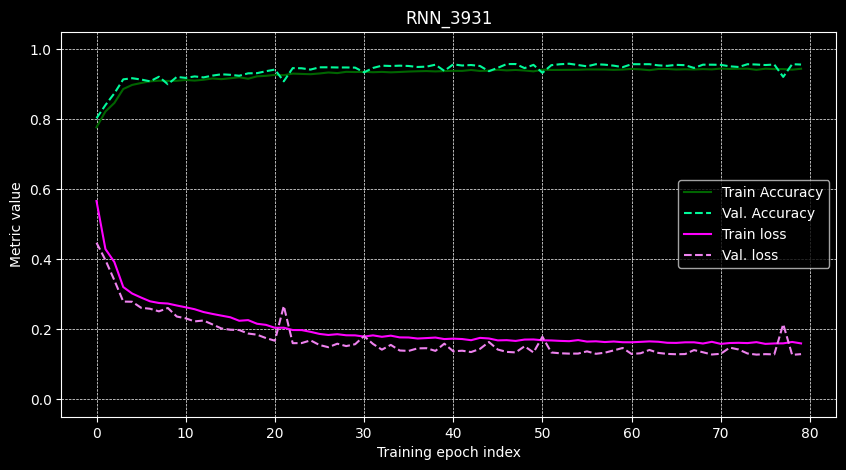

In [12]:
print(model.summary())
print()

# Print the model's results on testing data.
print(f"{model.name} results:")
for i, metric in enumerate(["Loss", "Accuracy", "Recall", "Precision"]):
    print(f"  {metric:>9s}: {results[i]:>5.3f}")


fig = plt.figure(figsize=(10,5))
fig.tight_layout()
ax = fig.add_subplot(111)


# Plot the binary accuracy and loss over training epochs.
ax.plot(history.epoch, history.history["binary_accuracy"], label="Train Accuracy", color='darkgreen', linestyle='-')
ax.plot(history.epoch, history.history["val_binary_accuracy"], label="Val. Accuracy", color='mediumspringgreen', linestyle='--')

ax.plot(history.epoch, history.history["loss"], label="Train loss", color='magenta', linestyle='-')
ax.plot(history.epoch, history.history["val_loss"], label="Val. loss", color='violet', linestyle='--')

ax.grid(which='both', linestyle='--', linewidth=0.5)

ax.set_ylim(-0.05, 1.05)
ax.legend()
ax.set_xlabel("Training epoch index")
ax.set_ylabel("Metric value")
ax.set_title(f"{model.name}")
plt.show()

#

In [13]:
# Save the model
# model.save('RNN_3931.keras')


In [14]:
# Load all filtered light curves for this field.

aperture = "opt" # Aperture size. Options: [opt, 066, 150, 500]

if os.path.isfile(f"lc_pkl/lc_{aperture}.pkl"):
    print(f"Loading existing file: lc_pkl/lc_{aperture}.pkl")
    with open(f"lc_pkl/lc_{aperture}.pkl", 'rb') as pfile:
        pkl_obj = pickle.load(pfile)
    all_lc = pkl_obj["all_lc"]
    useful_ids = pkl_obj["useful_ids"]
    assert all_lc.shape[0] == len(useful_ids), "Number of input light curves does not match the number of input source_id!"
    print(f"    Loaded {len(useful_ids)} light curves with total shape {all_lc.shape}.")
    
else:
    all_lc = []
    useful_ids = []
    
    all_ids = list(pd.unique(lc_df["source_id"]))
    
    np.random.shuffle(all_ids)
    
    skip_count = 0
    print(f"Formatting all {len(all_ids)} light curves.")
    for i,id in enumerate(all_ids):
        if i%int(0.1*len(all_ids)) == 0:
            print(f'  Progress: {i/len(all_ids)*100:5.1f}%   {datetime.now().strftime("%H:%M:%S")}')
        try:
            data = lc_df[lc_df["source_id"]==id][["mjd", f"mag_{aperture}", "filter"]]
            if len(data[data["filter"]=="q"]) < len(times_q)/2 or len(data[data["filter"]=="i"]) < len(times_i)/2 :
                skip_count += 1
                continue
            formatted_lc = format_lc(data, times, f"mag_{aperture}")
            all_lc.append(formatted_lc)
            useful_ids.append(id)
        except Exception as err:
            print(f"{id} failed:  {err}")
            continue
    
    all_lc = np.array(all_lc)
    
    print(f"Skipped {skip_count} light curves.\n")
    
    useful_ids = np.array(useful_ids) 
    print(f"Input data shape: {all_lc.shape}")
    print(f"Total unique source_id in all_ids: {len(useful_ids)}")
    assert all_lc.shape[0] == len(useful_ids), "Number of input light curves does not match the number of input source_id!"
        
    pickle_obj = {"useful_ids":useful_ids, "all_lc":all_lc}
    with open(f'lc_pkl/lc_{aperture}.pkl', "wb") as pfile: 
        pickle.dump(pickle_obj, pfile) 

#

Loading existing file: lc_pkl/lc_opt.pkl
    Loaded 104164 light curves with total shape (104164, 233).


In [15]:
# Use our model to make predictions on all of the light curves.
predictions = model.predict(all_lc)

# Combine object "source_id" and its predicted "label" into a Pandas DataFrame.
predictions_df0 = pd.DataFrame({"SOURCE_ID":useful_ids, "label":predictions.reshape(1,-1)[0]})

# Merge the predicted labels DataFrame with the catalog DataFrame (from our red_cat.fits file) to obtain X_POS and Y_POS for each label 
predictions_df = predictions_df0.merge(catalog_df, on="SOURCE_ID")

# Filter out nan labels.
predictions_df = predictions_df[~predictions_df["label"].isnull()]

assert predictions_df["label"].isnull().any() == False, "Prediction labels contain null values"

#

3256/3256 [==============================] - 17s 5ms/step


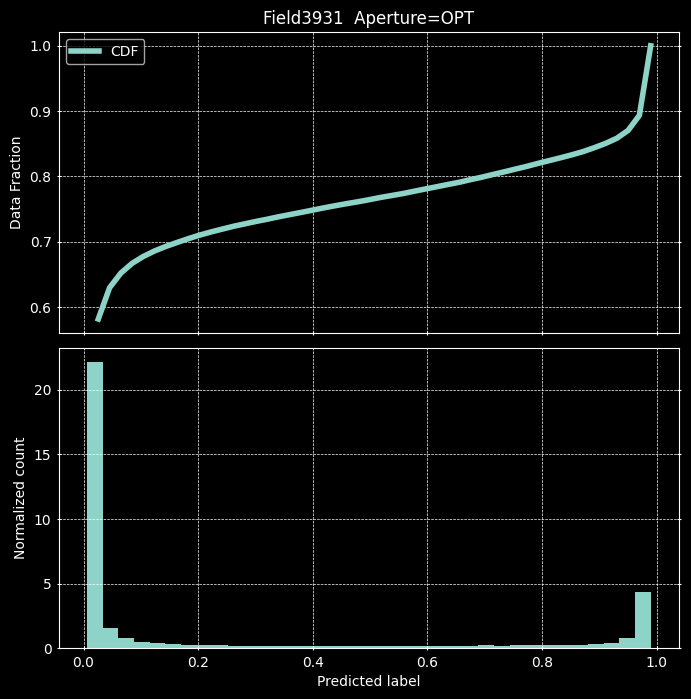

Number of predicted label<0.5: 79625  ( 76.4%)
Input data with label=0: 11140  ( 77.7%)

Number of predicted label>0.5: 24539  ( 23.6%)
Input data with label=1:  3192  ( 22.3%)


In [20]:
# Create a cumulative distribution function over the predicted labels.


from matplotlib.ticker import AutoMinorLocator, MultipleLocator

fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(hspace=0.05)
ax = fig.add_subplot(211)

count, bins_count = np.histogram(list(predictions_df["label"].values), bins=50) 
cdf = np.cumsum(count/sum(count))

aps = {"opt":"OPT", "150":"1.5xFWHM", "066":"0.66xFWHM", "500":"5xFWHM"}
ax.plot(bins_count[1:], cdf, label="CDF", linewidth=4)
ax.set_title(f"Field3931  Aperture={aps[aperture]}")
ax.set_ylabel("Data Fraction")
ax.tick_params(left=True, right=True, labelbottom=False, direction="inout", which="both")
ax.grid(color="white", linewidth=0.5, linestyle='--', which="both")
# ax.xaxis.set_minor_locator(MultipleLocator(0.1))
# ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.legend()

ax2 = fig.add_subplot(212, sharex=ax)
ax2.hist(predictions_df["label"].values, bins='scott', density=True) 
ax2.set_ylabel("Normalized count")
ax2.tick_params(left=True, right=True, direction="inout", which="both")
ax2.grid(color="white", linewidth=0.5, linestyle='--', which="both")
ax2.set_xlabel("Predicted label")

# plt.savefig(f"Field3931_CDF_{aperture}.jpg", dpi=100)
plt.show()

threshold = 0.5
bad_df = predictions_df[predictions_df["label"]>threshold]
good_df = predictions_df[predictions_df["label"]<threshold]

print(f"Number of predicted label<{threshold}: {len(good_df):>5d}  ({len(good_df)/len(predictions_df)*100:>5.1f}%)")
print(f"Input data with label=0: {len(label_df[label_df['label']==0]):>5d}  ({len(label_df[label_df['label']==0])/len(label_df)*100:>5.1f}%)")
print()

print(f"Number of predicted label>{threshold}: {len(bad_df):>5d}  ({len(bad_df)/len(predictions_df)*100:>5.1f}%)")
print(f"Input data with label=1: {len(label_df[label_df['label']==1]):>5d}  ({len(label_df[label_df['label']==1])/len(label_df)*100:>5.1f}%)")


#

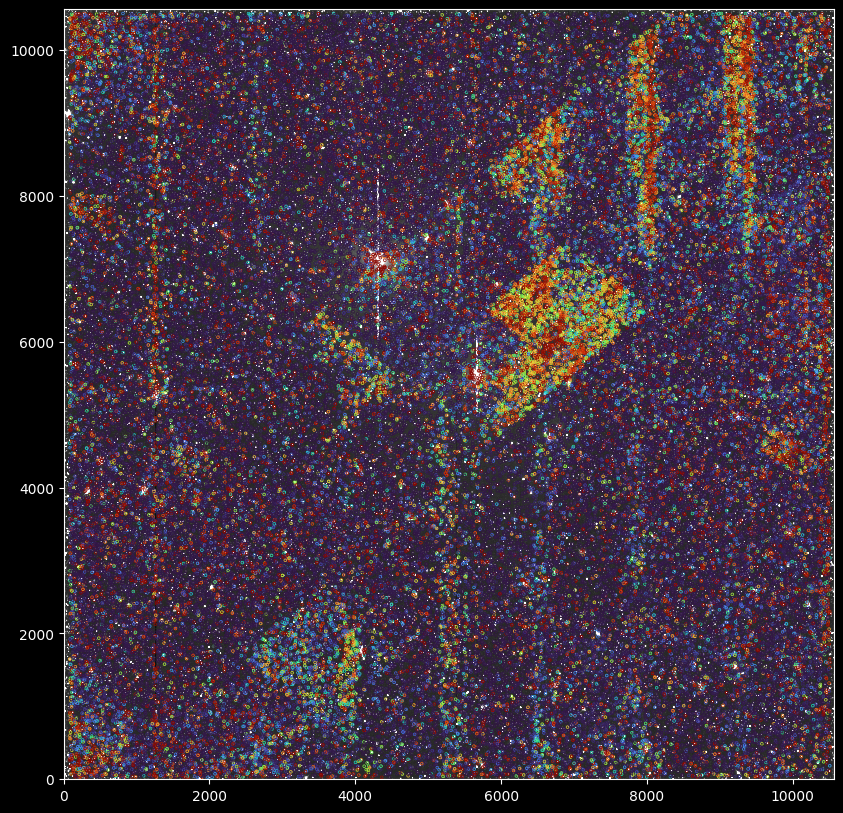

In [17]:
# Plot the predictions on an image of the field.

pdf = predictions_df.copy(deep=True)


two_color_ccd = False # Creates the CCD plot using only label=0 and label=1 values, resulting in only two region colors.
                    # Otherwise the plot will use the full label=[0,1] range with colorbar colors by label
if two_color_ccd:
    threshold = 0.5
    
    pdf.loc[pdf["label"]>threshold, "label"] = 1
    pdf.loc[pdf["label"]<=threshold, "label"] = 0

plot_ccd(pdf, image_file, 95, False)

#

In [18]:
def randomize_data(label_df, input_data, training_fraction, testing_fraction):
    indices = np.arange(len(input_data))
    np.random.shuffle(indices)
    
    training_indices = indices[:int(len(indices)*training_fraction)]
    validation_indices = indices[int(len(indices)*training_fraction): int(len(indices)*training_fraction) + int(len(indices)*validation_fraction)]
    testing_indices = indices[int(len(indices)*training_fraction) + int(len(indices)*validation_fraction):]
    xtrain = input_data[training_indices]
    xval = input_data[validation_indices]
    xtest = input_data[testing_indices]
    
    ytrain = np.array(label_df.iloc[training_indices]["label"].values)
    ytest = np.array(label_df.iloc[testing_indices]["label"].values)
    yval = np.array(label_df.iloc[validation_indices]["label"].values)

    # print(len(xtrain), len(ytrain), len(xtest), len(ytest), len(xval), len(yval))
    
    return([[xtrain, xval, xtest,],[ytrain, yval, ytest]])   

#

68/68 [==============================] - 0s 5ms/step - loss: 0.1679 - binary_accuracy: 0.9340 - recall_1: 0.8569 - precision_1: 0.8702
     Avg Loss = 0.152
 Avg Accuracy = 0.946
   Avg Recall = 0.867
Avg Precision = 0.894


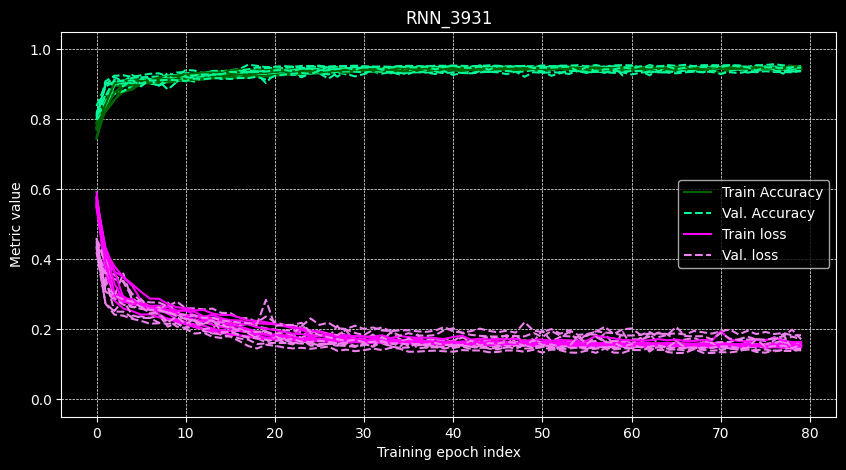

In [19]:
# K-fold cross validation (throw the model fit into a loop and print the average loss/acc/recall/prec)
from multiprocessing import Pool
from train_model import train_model # Need to read in the function and use __name__ == "__main__" for multiprocessing with Jupyter?
                                    # At the very least, __name__=="__main__" is required for the child processes.

if __name__ == "__main__":
    nfolds = 10
    input_datasets = [randomize_data(label_df, input_data, 0.7, 0.15) for k in range(nfolds)]
    pool = Pool(5)

    results = pool.map(train_model, input_datasets)
    results = np.array(results)

    print()
    print(f"{'Avg Loss':>13s} = {np.average(results[:,1]):<5.3f}")
    print(f"{'Avg Accuracy':>13s} = {np.average(results[:,2]):<5.3f}")
    print(f"{'Avg Recall':>13s} = {np.average(results[:,3]):<5.3f}")
    print(f"{'Avg Precision':>13s} = {np.average(results[:,4]):<5.3f}")


    fig = plt.figure(figsize=(10,5))
    fig.tight_layout()
    ax = fig.add_subplot(111)

    for k in range(nfolds):
        history = results[k][0]

        if k==nfolds-1:
            ax.plot(history.epoch, history.history["binary_accuracy"], label="Train Accuracy", color='darkgreen', linestyle='-')
            ax.plot(history.epoch, history.history["val_binary_accuracy"], label="Val. Accuracy", color='mediumspringgreen', linestyle='--')
            
            ax.plot(history.epoch, history.history["loss"], label="Train loss", color='magenta', linestyle='-')
            ax.plot(history.epoch, history.history["val_loss"], label="Val. loss", color='violet', linestyle='--')
        else:
            ax.plot(history.epoch, history.history["binary_accuracy"], color='darkgreen', linestyle='-')
            ax.plot(history.epoch, history.history["val_binary_accuracy"], color='mediumspringgreen', linestyle='--')
            
            ax.plot(history.epoch, history.history["loss"], color='magenta', linestyle='-')
            ax.plot(history.epoch, history.history["val_loss"], color='violet', linestyle='--')

    ax.grid(which='both', linestyle='--', linewidth=0.5)
    ax.legend()
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("Training epoch index")
    ax.set_ylabel("Metric value")
    ax.set_title(f"{model.name}")
    plt.show()

    
#